### **Load packages & functions**

In [ ]:
suppressMessages(library(extRemes))

prep_window <- function(rc = c(1,1), w = 4, h = 4, ...) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, ...) }

### **Load data**

In [2]:
ds <- "CPC"

if(ds == "CPC") {
    ts <- read.csv("ts/BrazilArgentinaParaguay-10day_heatwave_cpc_txdaily.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "tmax"))
} else if(ds == "ERA5") {
    ts <- read.csv("ts/era5_tx10day.csv")
} else if(ds == "ERA5 after 1970") {
    ts <- read.csv("ts/era5_tx10day.csv")
    ts <- ts[ts$year >= 1970,]
} else if(ds == "ERA5 after 1979") {
    ts <- read.csv("ts/era5_tx10day.csv")
    ts <- ts[ts$year >= 1979,]
} else if(ds == "MSWX") {
    ts <- read.csv("ts/MSWX_BrazilArgentinaParaguay-10day_heatwave_txdaily.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "tmax"))
} 

In [3]:
gmst <- read.fwf("/home/clair/Data/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))

# load detrended (NOT RESCALED) Nino3.4 timeseries, select September only
nino <- read.csv("data/nino3.4_detrended.csv")
nino <- rbind(nino, data.frame("time" = "2023-09-01", "nino3.4_det" = nino$nino3.4_det[nino$time == "2023-08-01"] + 0.2))

nino_sep_2023 <- nino$nino3.4_det[nino$time == "2023-08-01"] + 0.2
gmst_2023 <- gmst$gmst[gmst$year == 2023]

# September only
nino_sep <- nino[substr(nino$time,6,7) == "09",]
nino_sep$year <- as.integer(substr(nino_sep$time,1,4))

nino_augsep <- data.frame("time" = nino_sep$time, 
                          "nino3.4_det" = filter(nino$nino3.4_det, rep(0.5,2), sides = 1)[substr(nino$time,6,7) == "09"])
nino_augsep$year <- as.integer(substr(nino_augsep$time,1,4))

In [4]:
# merge data & covariates together
df_sep <- merge(nino_sep[,c("year", "nino3.4_det")], merge(gmst, ts, all = F), all = F)
df_augsep <- merge(nino_augsep[,c("year", "nino3.4_det")], merge(gmst, ts, all = F), all = F)

## **September ENSO as covariate**

### **Quick look at linear model**

In [207]:
summary(lm(tmax ~ gmst, data = df_sep))


Call:
lm(formula = tmax ~ gmst, data = df_sep)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0846 -0.6458 -0.1981  0.4794  2.2573 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  28.0724     0.3770  74.462  < 2e-16 ***
gmst          3.8854     0.6456   6.019 3.44e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.08 on 43 degrees of freedom
Multiple R-squared:  0.4572,	Adjusted R-squared:  0.4446 
F-statistic: 36.22 on 1 and 43 DF,  p-value: 3.436e-07


In [208]:
summary(lm(tmax ~ gmst + nino3.4_det, data = df_sep))


Call:
lm(formula = tmax ~ gmst + nino3.4_det, data = df_sep)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8813 -0.6466 -0.2292  0.5364  2.2186 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  27.8913     0.4033  69.166  < 2e-16 ***
gmst          4.0486     0.6558   6.174 2.23e-07 ***
nino3.4_det   0.2584     0.2120   1.219     0.23    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.074 on 42 degrees of freedom
Multiple R-squared:  0.4758,	Adjusted R-squared:  0.4508 
F-statistic: 19.06 on 2 and 42 DF,  p-value: 1.288e-06


### **Fit model with & without Nino3.4 covariate**

In [209]:
mdl_gmst_nino <- fevd(tmax, df_sep, location.fun = ~ gmst + nino3.4_det)
mdl_gmst <- fevd(tmax, df_sep, location.fun = ~ gmst)
mdl_nino <- fevd(tmax, df_sep, location.fun = ~ nino3.4_det)

In [210]:
strip(mdl_gmst_nino)["mu2"] * nino_sep_2023

mu2 
0.3912951

In [211]:
lr.test(mdl_gmst, mdl_gmst_nino) # any evidence for sufficient improvement in the model to include the extra covariate?


	Likelihood-ratio Test

data:  tmaxtmax
Likelihood-ratio = 1.7208, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.1896
alternative hypothesis: greater


### **Compare fitted model over time**

In [212]:
effect_gmst <- round(strip(mdl_gmst)["mu1"] * c(gmst_2023), 1)
effect_gmst_nino <- paste(round(strip(mdl_gmst_nino)[c("mu1", "mu2")] * c(gmst_2023, nino_sep_2023), 1), collapse = " + ")

In [213]:
# compare fitted models with & without detrended Nino3.4 index
prep_window(c(1,2)); par(mfrow = c(1,1))
nd <- 7

png(paste0("fig/gev-with-and-without-nino34_",gsub(" ","-",ds),".png"), height = 480, width = 480 * 2); par(cex = 1.4, mar = c(3,4.2,1,1)); {
    
    plot(ts$year+0.5, ts$tmax, type = "S", xlab = "", ylab = expression("Temperature ("*degree*"C)"), lwd = 2, cex.lab = 1.2, main = ds)
    # lines(df_sep$year, filter(df_sep$tmax, rep(1/nd, nd)), lwd = 2)

    lines(df_sep$year, findpars(mdl_gmst)$location, col = "darkblue", lwd = 3)
    # lines(df_sep$year, return.level(mdl_gmst, 10), col = "darkblue", lwd = 2, lty = 2)

    lines(df_sep$year, findpars(mdl_gmst_nino)$location, col = "darkred", lwd = 3, lty = "32")
    # lines(df_sep$year, return.level(mdl_gmst_nino, 10), col = "darkred", lwd = 2, lty = 2)
    
    legend("bottomright", legend = c(paste0("GMST only: ", effect_gmst),
                                 paste0("GMST + Nino3.4: ", effect_gmst_nino)),
           lty = c("solid","32"), lwd = 3, col = c("darkblue", "darkred"), bty = "n")
    
}; dev.off()

png 
  2

---
## **August/September ENSO as covariate**

### **Quick look at linear model**

In [131]:
summary(lm(tmax ~ gmst, data = df_augsep))


Call:
lm(formula = tmax ~ gmst, data = df_augsep)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.47672 -0.85773  0.07944  0.85728  2.88728 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  30.3142     0.2862 105.934  < 2e-16 ***
gmst          3.1097     0.5366   5.795 4.05e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.173 on 52 degrees of freedom
Multiple R-squared:  0.3924,	Adjusted R-squared:  0.3807 
F-statistic: 33.58 on 1 and 52 DF,  p-value: 4.051e-07


In [132]:
summary(lm(tmax ~ gmst + nino3.4_det, data = df_augsep))


Call:
lm(formula = tmax ~ gmst + nino3.4_det, data = df_augsep)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4416 -0.8486  0.1148  0.8196  3.0259 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  30.2229     0.3072  98.384  < 2e-16 ***
gmst          3.1559     0.5410   5.833 3.74e-07 ***
nino3.4_det   0.1816     0.2178   0.834    0.408    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.176 on 51 degrees of freedom
Multiple R-squared:  0.4006,	Adjusted R-squared:  0.3771 
F-statistic: 17.04 on 2 and 51 DF,  p-value: 2.15e-06


### **Fit model with & without Nino3.4 covariate**

In [133]:
mdl_gmst_nino <- fevd(tmax, df_augsep, location.fun = ~ gmst + nino3.4_det)
mdl_gmst <- fevd(tmax, df_augsep, location.fun = ~ gmst)
mdl_nino <- fevd(tmax, df_augsep, location.fun = ~ nino3.4_det)

In [134]:
strip(mdl_gmst)
strip(mdl_gmst_nino)

mu0        mu1      scale      shape 
29.9325422  2.9804974  1.1039313 -0.2185875

mu0        mu1        mu2      scale      shape 
29.8325393  3.0531333  0.1712654  1.0956640 -0.2116944

In [135]:
lr.test(mdl_gmst, mdl_gmst_nino) # any evidence for sufficient improvement in the model to include the extra covariate?


	Likelihood-ratio Test

data:  tmaxtmax
Likelihood-ratio = 0.5885, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.443
alternative hypothesis: greater


### **Compare fitted model over time**

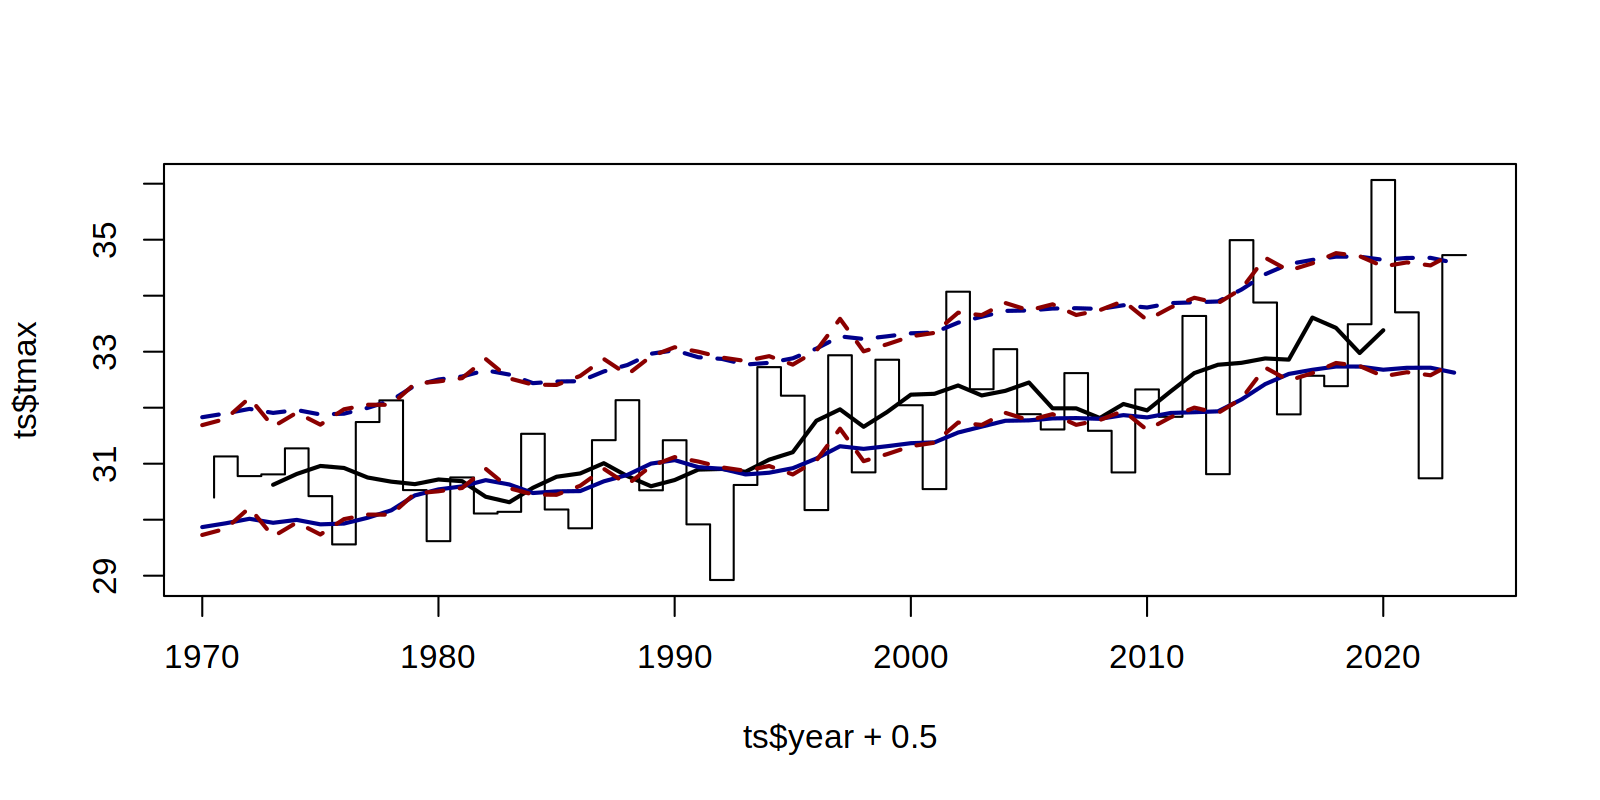

In [136]:
# compare fitted models with & without detrended Nino3.4 index
prep_window(c(1,2)); par(mfrow = c(1,1))
nd <- 7

plot(ts$year+0.5, ts$tmax, type = "S")
lines(df_augsep$year, filter(df_augsep$tmax, rep(1/nd, nd)), lwd = 2)

lines(df_augsep$year, findpars(mdl_gmst)$location, col = "darkblue", lwd = 2)
lines(df_augsep$year, return.level(mdl_gmst, 10), col = "darkblue", lwd = 2, lty = 2)

lines(df_augsep$year, findpars(mdl_gmst_nino)$location, col = "darkred", lwd = 2, lty = 2)
lines(df_augsep$year, return.level(mdl_gmst_nino, 10), col = "darkred", lwd = 2, lty = 2)